In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import numpy as np

In [2]:
customers = pd.read_csv(r"C:\Users\nanin\OneDrive\Desktop\Customers (1).csv")
products = pd.read_csv(r"C:\Users\nanin\OneDrive\Desktop\Products.csv")
transactions = pd.read_csv(r"C:\Users\nanin\OneDrive\Desktop\Transactions.csv")

In [3]:
print("Customers Dataset:\n", customers.head())
print("\nProducts Dataset:\n", products.head())
print("\nTransactions Dataset:\n", transactions.head())


Customers Dataset:
   CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Dataset:
   ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Dataset:
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166

In [4]:
print("\nMissing values in Customers:\n", customers.isnull().sum())
print("\nMissing values in Products:\n", products.isnull().sum())
print("\nMissing values in Transactions:\n", transactions.isnull().sum())


Missing values in Customers:
 CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

Missing values in Products:
 ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64

Missing values in Transactions:
 TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [5]:
print("\nCustomers Dataset Statistics:\n", customers.describe(include='all'))
print("\nProducts Dataset Statistics:\n", products.describe(include='all'))
print("\nTransactions Dataset Statistics:\n", transactions.describe())


Customers Dataset Statistics:
        CustomerID      CustomerName         Region  SignupDate
count         200               200            200         200
unique        200               200              4         179
top         C0001  Lawrence Carroll  South America  2024-11-11
freq            1                 1             59           3

Products Dataset Statistics:
        ProductID            ProductName Category       Price
count        100                    100      100  100.000000
unique       100                     66        4         NaN
top         P001  ActiveWear Smartwatch    Books         NaN
freq           1                      4       26         NaN
mean         NaN                    NaN      NaN  267.551700
std          NaN                    NaN      NaN  143.219383
min          NaN                    NaN      NaN   16.080000
25%          NaN                    NaN      NaN  147.767500
50%          NaN                    NaN      NaN  292.875000
75%         

In [6]:
merged_data = pd.merge(transactions, customers, on='CustomerID', how='left')
merged_data = pd.merge(merged_data, products, on='ProductID', how='left')

In [7]:
print("\nMerged Dataset:\n", merged_data.head())


Merged Dataset:
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving

In [8]:
customer_summary = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()

In [9]:
customer_data = pd.merge(customer_summary, customers, on='CustomerID', how='left')

In [10]:
customer_data_encoded = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)
scaler = StandardScaler()
numerical_features = ['TotalValue', 'Quantity']
customer_data_encoded[numerical_features] = scaler.fit_transform(customer_data_encoded[numerical_features])

In [11]:
similarity_matrix = cosine_similarity(customer_data_encoded.drop(columns=['CustomerID', 'CustomerName', 'SignupDate']))
similarity_df = pd.DataFrame(similarity_matrix, index=customer_data['CustomerID'], columns=customer_data['CustomerID'])

In [12]:
lookalike_results = {}
for customer_id in similarity_df.index:
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).iloc[1:4]
    lookalike_results[customer_id] = list(zip(similar_customers.index, similar_customers.values))

In [13]:
lookalike_data = []
for customer_id, lookalikes in lookalike_results.items():
    for similar_id, score in lookalikes:
        lookalike_data.append([customer_id, similar_id, score])

In [14]:
lookalike_df = pd.DataFrame(lookalike_data, columns=['CustomerID', 'SimilarCustomerID', 'SimilarityScore'])
lookalike_df.to_csv("/mnt/data/Lookalike.csv", index=False)
print("\nLookalike recommendations saved to Lookalike.csv")


Lookalike recommendations saved to Lookalike.csv


In [15]:
clustering_features = customer_data_encoded.drop(columns=['CustomerID', 'CustomerName', 'SignupDate'])

In [16]:
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data_encoded['Cluster'] = kmeans.fit_predict(clustering_features)

In [17]:
db_index = davies_bouldin_score(clustering_features, customer_data_encoded['Cluster'])
print("\nDavies-Bouldin Index for Clustering: {:.2f}".format(db_index))


Davies-Bouldin Index for Clustering: 1.21


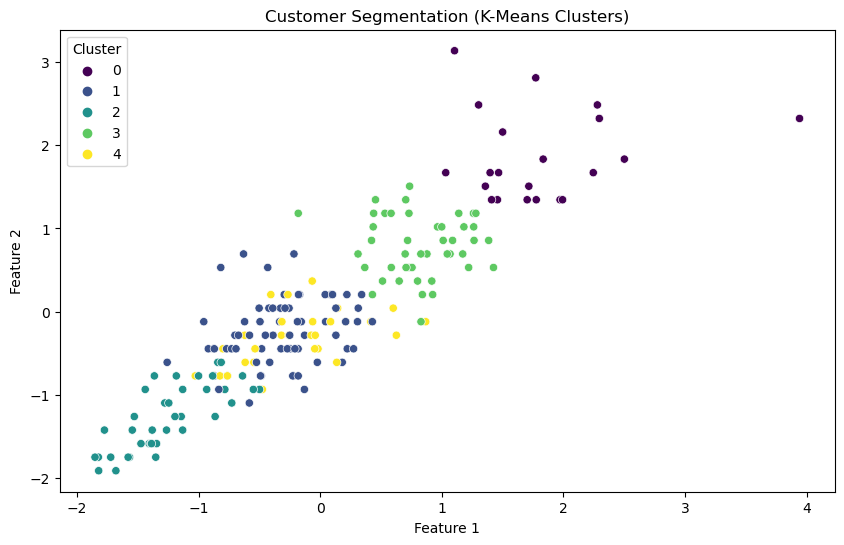

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=clustering_features.iloc[:, 0], y=clustering_features.iloc[:, 1], 
                hue=customer_data_encoded['Cluster'], palette='viridis')
plt.title('Customer Segmentation (K-Means Clusters)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.show()

In [19]:
customer_data_encoded[['CustomerID', 'Cluster']].to_csv("/mnt/data/CustomerClusters.csv", index=False)
print("\nCustomer cluster assignments saved to CustomerClusters.csv")


Customer cluster assignments saved to CustomerClusters.csv


In [20]:
merged_data.to_csv("/mnt/data/MergedDataset.csv", index=False)